# Validação de Modelos (Cross Validation)

Há sempre uma necessidade de validar a estabilidade do seu modelo de _Machine Learning_. Quer dizer, você simplesmente não pode ajustar o modelo aos seus dados de treinamento e esperar que funcione com precisão para os dados reais que nunca viu antes. Você precisa de algum tipo de garantia de que o seu modelo tenha corrigido a maioria dos padrões dos dados, e não esteja captando muito o ruído ou, em outras palavras, seu viés e variação baixos.

Este processo de decidir se os resultados numéricos, quantificando relações hipotetizadas entre variáveis, são aceitáveis ​​como descrições dos dados, é conhecido como validação. Geralmente, uma estimativa de erro para o modelo é feita após o treinamento, mais conhecido como avaliação de resíduos. Nesse processo, é feita uma estimativa numérica da diferença nas respostas previstas e originais, também chamada de erro de treinamento. No entanto, isso só nos dá uma idéia sobre o quão bem o nosso modelo faz em dados usados ​​para treiná-lo. Agora é possível que o modelo esteja subajustando ou super adaptando os dados. Assim, o problema com essa técnica de avaliação é que ela não fornece uma indicação de quão bem o aluno irá generalizar para um conjunto de dados independente / invisível. Obter essa ideia sobre o nosso modelo é conhecido como validação cruzada.

[Cross-Validation in Machine Learning](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f)

## Hiperparâmetros e validação de modelo

Na seção anterior, vimos a receita básica para aplicar um modelo de aprendizado de máquina supervisionado:

- Escolha uma classe de modelo
- Escolha os hiperparâmetros do modelo
- Ajustar o modelo aos dados de treinamento
- Use o modelo para prever rótulos para novos dados

As duas primeiras partes disso - a escolha do modelo e a escolha dos hiperparâmetros - talvez sejam a parte mais importante do uso dessas ferramentas e técnicas de maneira eficaz. Para fazer uma escolha informada, precisamos de uma maneira de validar que nosso modelo e nossos hiperparâmetros são adequados aos dados. Enquanto isso pode parecer simples, existem algumas armadilhas que você deve evitar para fazer isso de forma eficaz.

### Pensando em Validação de Modelo

<br>
<img src="img\validation_set.png" style="height:300px">
<br>

Em princípio, a validação do modelo é muito simples: depois de escolher um modelo e seus hiperparâmetros, podemos estimar o quão eficaz ele é aplicando-o a alguns dos dados de treinamento e comparando a previsão com o valor conhecido.

As seções a seguir primeiro mostram uma abordagem simplificada da validação do modelo e por que ele falha, antes de explorar o uso de conjuntos de validação e validação cruzada para uma avaliação de modelo mais robusta.


## Exemplo

Vamos estudar um exemplo do uso de validação cruzada para calcular as curvas de validação de uma classe de modelos. Aqui, vamos usar um modelo de *regressão polinomial*: é um modelo linear generalizado, em que o grau dos polinômios é um parâmetro configurável. 

Por exemplo, um polinômio de grau 1 ajusta uma linha reta aos dados; para os parâmetros do modelo $a$ y $b$:

$$
y = ax + b
$$

Um polinômio de grau 3 ajusta uma curva cúbica aos dados; para parâmetros $a, b, c, d$: 

$$
y = ax^3 + bx^2 + cx + d
$$

Isso pode ser generalizado a qualquer número de recursos polinomiais.

Em Scikit-Learn, é possível implementar esse modelo com uma simples regressão linear combinada com o pré-processador polinomial (polynomial preprocessor).

Usar um *pipeline* para organizar essas operações sequencialmente. 

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),LinearRegression(**kwargs))

Agora vamos criar alguns dados sintéticos (artificiais, inventados), 
aos quais o nosso modelo será ajustado em seguida.

In [2]:


import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)



Agora podemos visualizar nossos dados, junto com os ajustes polinomiais de vários graus.

** OBERVAÇÃO: ** Este código é auxiliar e não é necessário entender todos os detalhes para seguir o exemplo.

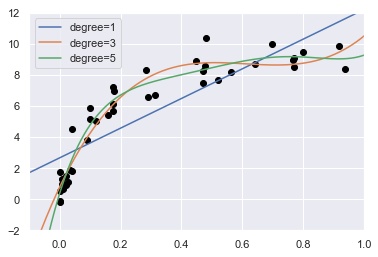

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Nesse caso, "o botão" que controla a complexidade do modelo é o grau do polinômio, que pode ser qualquer inteiro não negativo.

Uma interessante pergunta a ser feita: qual grau de polinômio fornece um compromisso apropriado entre viés (subajuste) e variância (superajuste)?

Podemos prosseguir visualizando a curva de validação para este conjunto de dados e modelo específicos; isso pode ser feito facilmente usando a função ``validation_curve`` fornecida por Scikit-Learn.

Dado um modelo, um conjunto de dados, um nome de parâmetro e um intervalo a ser explorado, essa função calculará automaticamente tanto o score de treinamento como o score de validação ao longo do intervalo: 

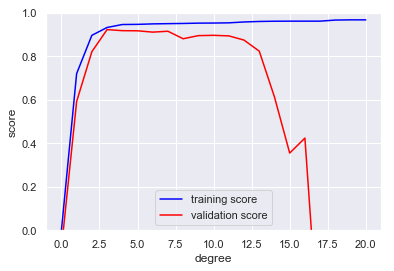

In [4]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y, 'polynomialfeatures__degree'
, degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Este gráfico mostra precisamente o comportamento qualitativo que esperamos: o score de treinamento sempre é maior que o score de validação; o score de treinamento cresce lentamente junto com a complexidade do modelo; e o score de validação atinge um máximo antes de finalmente começar a cair à medida que o modelo é superajustado. 

A partir da curva de validação, é possível interpretar que o compromisso ideal entre viés e variância é encontrado com um polinômio de terceira ordem; podemos calcular e mostrar esse ajuste sobre os dados originais: 

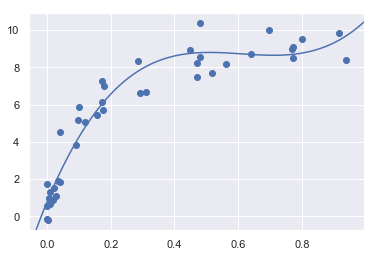

In [5]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notar que encontrar esse modelo ideal não exigiu que fosse calculado apenas o score de treinamento, mas examinando o relacionamento entre os scores de treinamento e validação, conseguimos obter um insight válido sobre o desempenho do modelo.

# Dicas para os alunos participarem da comunidade de Machine Learning e Ciência de Dados

### Ciênica de dados do Banco BCG
[BCG](https://www.bcg.com/pt-br/default.aspx)

### Google oferece projetos para participação remunerada
[Google Summer of Code](https://summerofcode.withgoogle.com/)

### Eventos na área de Ciência de Dados
[Meetup](https://www.meetup.com/pt-BR/#_=_)

### Canal no Youtube do Nubank
[Nubank on the Stage](https://www.youtube.com/results?search_query=nubank+on+the+stage)

### Comunidade organizadora de eventos mundias em Ciência de Dados
[PAPIs](https://www.papis.io/)

### Ferramenta do Facebook para séries temporais
[FBProphet](https://facebook.github.io/prophet/docs/quick_start.html)

### Comunidade de Ciência de Dados
[Data Hackers](https://datahackers.com.br/0)

### Livro com conceitos de Python para Machine Learning
[Python Data Science Handbook: Essential Tools for Working with Data](https://play.google.com/store/books/details?id=6omNDQAAQBAJ&rdid=book-6omNDQAAQBAJ&rdot=1&source=gbs_atb&pcampaignid=books_booksearch_atb)
